<a href="https://colab.research.google.com/github/Hami-611/21Days_AI-ML_Challenge/blob/main/Day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# Import libraries
# Heart Disease Prediction without Pipelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

sns.set_style("whitegrid")


In [115]:
# Download the dataset using the Kaggle Hub API
import kagglehub

path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Data Inspection and Cleaning


In [116]:
print("=== INITIAL DATA INSPECTION ===")
print("Dataset Info:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

=== INITIAL DATA INSPECTION ===
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Missing values per column:
id            0
age           0
sex           0
dataset

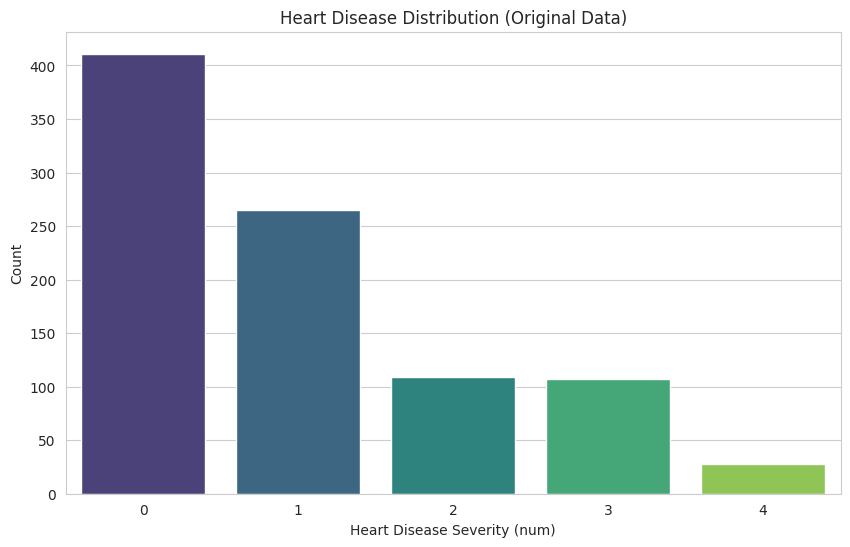

Target variable distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Percentage distribution:
num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


In [117]:
# Distribution of the target variable

plt.figure(figsize=(10, 6))
sns.countplot(x='num', data=df, palette="viridis")
plt.title("Heart Disease Distribution (Original Data)")
plt.xlabel("Heart Disease Severity (num)")
plt.ylabel("Count")
plt.show()

print("Target variable distribution:")
print(df['num'].value_counts())
print("\nPercentage distribution:")
print(df['num'].value_counts(normalize=True) * 100)

Handling Missing Values and Feature Seperation

In [118]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [119]:
# Drop irrelevant/problematic columns and handle missing values BEFORE feature separation

# 1. Drop irrelevant column 'id'
print("Shape before dropping 'id':", df.shape)
df = df.drop(columns=['id'])
print("Shape after dropping 'id':", df.shape)

# 2. Drop columns with a very high percentage of missing values
cols_to_drop_high_missing = ['slope', 'ca', 'thal']
print(f"Dropping columns with high missing values: {cols_to_drop_high_missing}")
df = df.drop(columns=cols_to_drop_high_missing)
print("Shape after dropping high missing value columns:", df.shape)


# 3. Handle remaining missing values
print("\nHandling remaining missing values...")
print("Missing values before treatment:", df.isnull().sum().sum())

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled numerical column '{col}' with median: {median_val}")
        else:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Filled categorical column '{col}' with mode: {mode_val}")

print("Missing values after treatment:", df.isnull().sum().sum())

# 4. Separate numerical and categorical columns from the cleaned data
target = "num"
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove(target) if target in num_cols else None

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nCleaned and Separated Features:")
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Shape before dropping 'id': (920, 16)
Shape after dropping 'id': (920, 15)
Dropping columns with high missing values: ['slope', 'ca', 'thal']
Shape after dropping high missing value columns: (920, 12)

Handling remaining missing values...
Missing values before treatment: 353
Filled numerical column 'trestbps' with median: 130.0
Filled numerical column 'chol' with median: 223.0
Filled categorical column 'fbs' with mode: False
Filled categorical column 'restecg' with mode: normal
Filled numerical column 'thalch' with median: 140.0
Filled categorical column 'exang' with mode: False
Filled numerical column 'oldpeak' with median: 0.5
Missing values after treatment: 0

Cleaned and Separated Features:
Numerical columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical columns: ['sex', 'dataset', 'cp', 'restecg']


In [120]:
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


Encoding

In [121]:
# One-hot encode categorical variables
print("\n=== ENCODING CATEGORICAL VARIABLES ===")
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print(f"Shape after encoding: {df_encoded.shape}")


=== ENCODING CATEGORICAL VARIABLES ===
Shape after encoding: (920, 17)


In [122]:
# Scale numerical columns
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Final dataset
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

print("Shape after preprocessing:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Shape after preprocessing:
X shape: (920, 16)
y shape: (920,)


In [123]:
X

,age,trestbps,chol,fbs,thalch,exang,oldpeak,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality
0,1.007386,0.705176,0.303643,True,0.489727,False,1.368109,True,False,False,False,False,False,True,False,False
1,1.432034,1.518569,0.789967,False,-1.181478,True,0.611589,True,False,False,False,False,False,False,False,False
2,1.432034,-0.650479,0.266939,False,-0.345875,True,1.651804,True,False,False,False,False,False,False,False,False
3,-1.752828,-0.108217,0.459634,False,1.961979,False,2.502889,True,False,False,False,False,True,False,True,False
4,-1.328180,-0.108217,0.037541,False,1.365120,False,0.517024,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,-0.270895,1.221235,True,0.648889,False,-0.806886,False,False,False,True,False,False,False,False,True
916,0.901224,-0.108217,-0.558893,False,0.091821,False,-0.334061,True,False,False,True,False,False,True,False,True
917,0.158089,-0.542026,0.211884,True,-1.499803,False,-0.806886,True,False,False,True,False,False,False,False,True
918,0.476575,-0.108217,1.698383,True,0.091821,False,-0.334061,True,False,False,True,False,False,False,False,False


Train and Test

In [124]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (736, 16), (736,)
Testing set: (184, 16), (184,)


Logistic Regression

In [125]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_lr, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_lr, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Performance
Accuracy: 0.5978260869565217
Precision: 0.5469644485948834
Recall: 0.5978260869565217
F1 Score: 0.5671384023840522

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.51      0.62      0.56        53
           2       0.14      0.05      0.07        22
           3       0.17      0.19      0.18        21
           4       0.00      0.00      0.00         6

    accuracy                           0.60       184
   macro avg       0.33      0.35      0.33       184
weighted avg       0.55      0.60      0.57       184



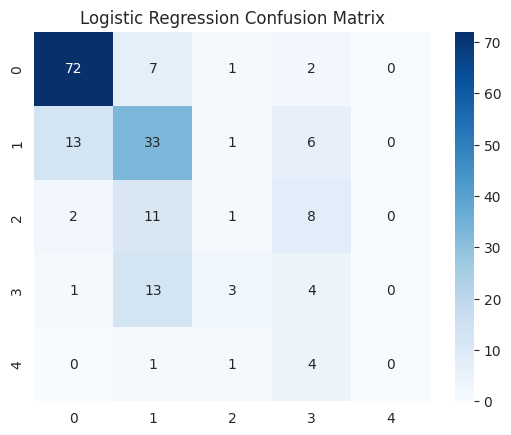

In [126]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Random Forest

Random Forest Performance
Accuracy: 0.5760869565217391
Precision: 0.5346700905322523
Recall: 0.5760869565217391
F1 Score: 0.5538712415698815

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        82
           1       0.51      0.55      0.53        53
           2       0.21      0.18      0.20        22
           3       0.18      0.14      0.16        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.33      0.35      0.34       184
weighted avg       0.53      0.58      0.55       184



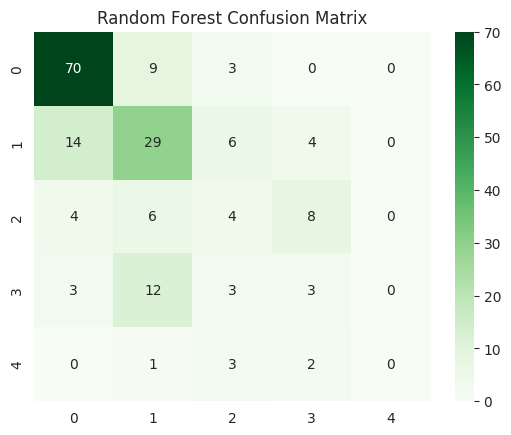

In [127]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_rf, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_rf, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()

K-Nearest Neighbors

KNN Performance
Accuracy: 0.5543478260869565
Precision: 0.49691716994410756
Recall: 0.5543478260869565
F1 Score: 0.5206699712277806

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77        82
           1       0.47      0.58      0.52        53
           2       0.07      0.05      0.06        22
           3       0.25      0.14      0.18        21
           4       0.00      0.00      0.00         6

    accuracy                           0.55       184
   macro avg       0.30      0.32      0.31       184
weighted avg       0.50      0.55      0.52       184



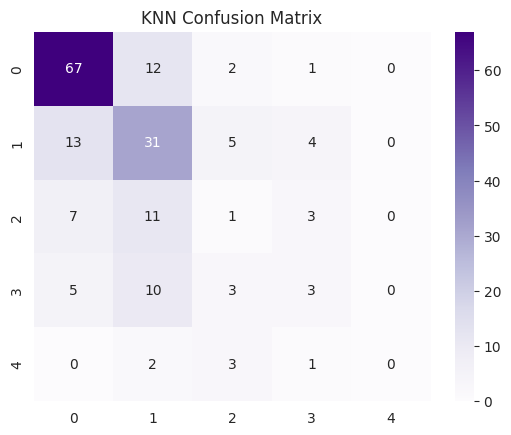

In [128]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("KNN Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_knn, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_knn, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Purples")
plt.title("KNN Confusion Matrix")
plt.show()


Support Vector Machine

SVM Performance
Accuracy: 0.5869565217391305
Precision: 0.49828933144150533
Recall: 0.5869565217391305
F1 Score: 0.5354637237959126

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82        82
           1       0.49      0.60      0.54        53
           2       0.10      0.05      0.06        22
           3       0.10      0.05      0.06        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.29      0.32      0.30       184
weighted avg       0.50      0.59      0.54       184



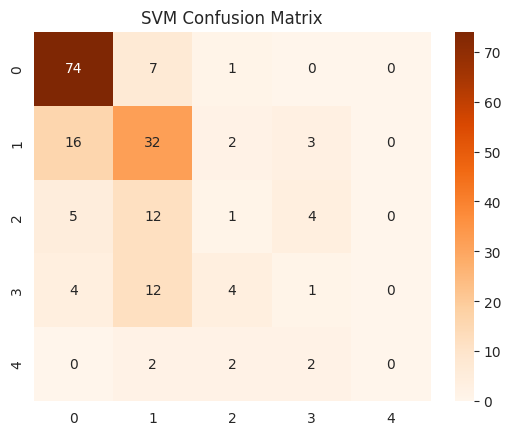

In [130]:
#svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_svm, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_svm, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Oranges")
plt.title("SVM Confusion Matrix")
plt.show()

Comparing Results

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.597826,0.546964,0.597826,0.567138
1,Random Forest,0.576087,0.534670,0.576087,0.553871
2,KNN,0.554348,0.496917,0.554348,0.520670
3,SVM,0.586957,0.498289,0.586957,0.535464


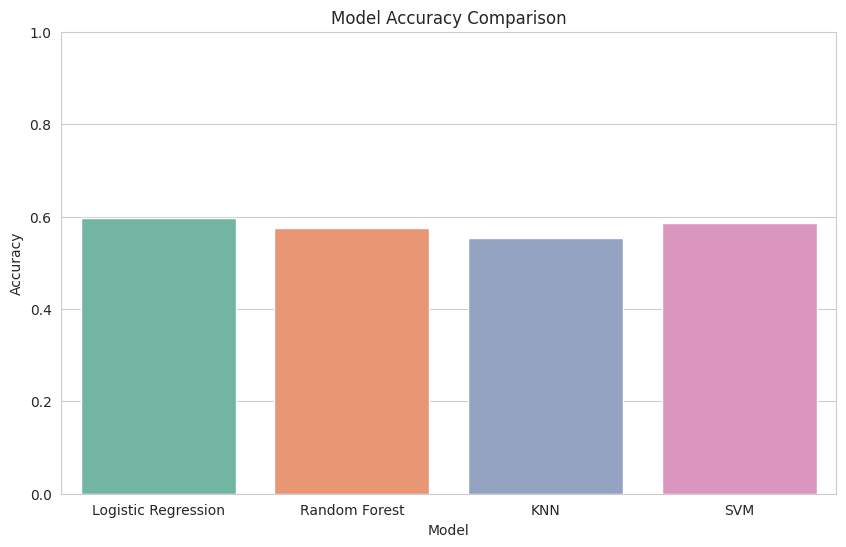

In [131]:
# Collect results
results = {
    "Model": ["Logistic Regression", "Random Forest", "KNN", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr, average="weighted"),
        precision_score(y_test, y_pred_rf, average="weighted"),
        precision_score(y_test, y_pred_knn, average="weighted"),
        precision_score(y_test, y_pred_svm, average="weighted")
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr, average="weighted"),
        recall_score(y_test, y_pred_rf, average="weighted"),
        recall_score(y_test, y_pred_knn, average="weighted"),
        recall_score(y_test, y_pred_svm, average="weighted")
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr, average="weighted"),
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_knn, average="weighted"),
        f1_score(y_test, y_pred_svm, average="weighted")
    ]
}

results_df = pd.DataFrame(results)

# Display results
print("Model Performance Comparison:")
display(results_df)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="Set2")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


Feature Importance

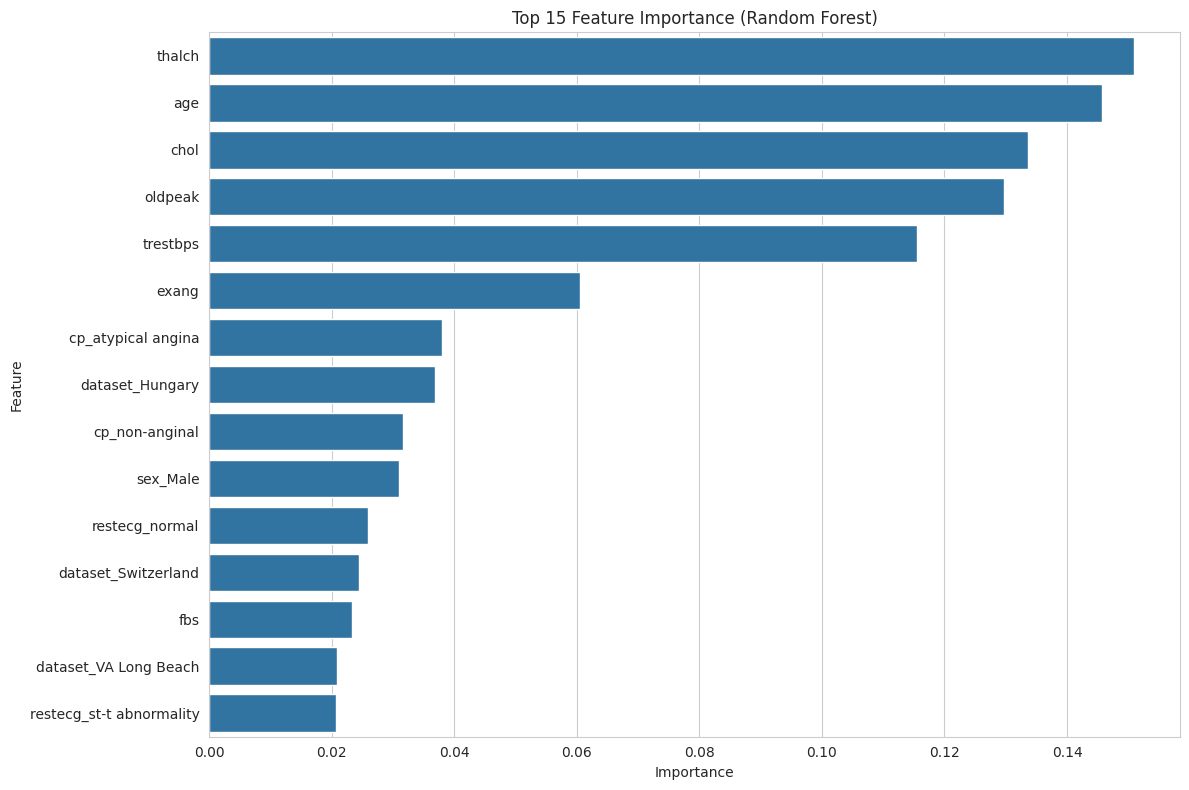

In [132]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Project Summary and Reasons for Low Accuracy

So far, we have loaded the heart disease dataset, performed initial data inspection and cleaning by handling missing values and dropping irrelevant columns. We then preprocessed the data by one-hot encoding categorical features and scaling numerical features. Finally, we trained and evaluated several baseline classification models: Logistic Regression, Random Forest, K-Nearest Neighbors, and Support Vector Machine.

Despite these steps, the models have shown relatively low accuracy. Here are the primary reasons contributing to this:

1.  **Class Imbalance**: The target variable, representing different levels of heart disease severity, is imbalanced. This means some severity levels have significantly fewer data points than others, making it hard for the models to learn and predict these minority classes accurately.
2.  **Data Quality and Feature Informativeness**: Even after handling missing values and dropping columns with a high percentage of missing data, the remaining features might not be sufficiently informative or complex enough to capture the nuances required to distinguish between all severity levels of heart disease with high accuracy.
3.  **Model Limitations with Default Parameters**: The models were trained using their default hyperparameters. These default settings are not always optimal for a specific dataset and problem.

To address the third point and potentially improve the model's performance, we will now proceed with **hyperparameter tuning**. By systematically searching for the best combination of parameters for our models, we hope to unlock better performance on this dataset.

Hyperparameter tuning for logistic regression


In [133]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000]
}

# Instantiate GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)

# Fit GridSearchCV to the training data
grid_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy:", grid_search_lr.best_score_)

Best parameters for Logistic Regression: {'C': 100, 'max_iter': 1000}
Best cross-validation accuracy: 0.5856223570509285


Train and evaluate the Logistic Regression model with the best hyperparameters found.


Tuned Logistic Regression Performance
Accuracy: 0.592391304347826
Precision: 0.5559534308476014
Recall: 0.592391304347826
F1 Score: 0.5693313298440601

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        82
           1       0.52      0.62      0.57        53
           2       0.14      0.05      0.07        22
           3       0.14      0.19      0.16        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.33      0.34      0.33       184
weighted avg       0.56      0.59      0.57       184



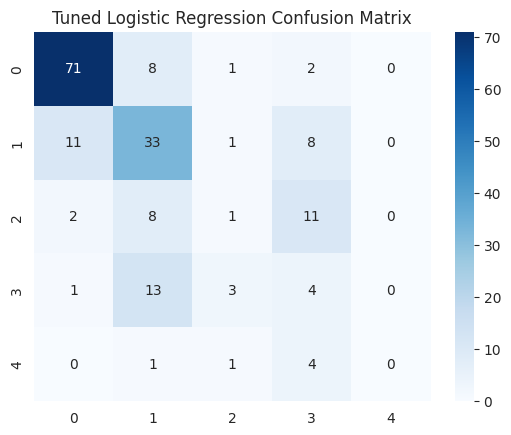

In [134]:
# Instantiate Logistic Regression with best hyperparameters
log_reg_tuned = LogisticRegression(**grid_search_lr.best_params_)

# Train the model
log_reg_tuned.fit(X_train, y_train)

# Make predictions
y_pred_lr_tuned = log_reg_tuned.predict(X_test)

# Evaluate the model
print("Tuned Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))
print("Precision:", precision_score(y_test, y_pred_lr_tuned, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_lr_tuned, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_lr_tuned, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_tuned))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tuned), annot=True, fmt="d", cmap="Blues")
plt.title("Tuned Logistic Regression Confusion Matrix")
plt.show()

Hyperparameter tuning for random forest


In [135]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy:", grid_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.5965526751241036


Train and evaluate the Random Forest model with the best hyperparameters found.


Tuned Random Forest Performance
Accuracy: 0.6032608695652174
Precision: 0.5538836439812741
Recall: 0.6032608695652174
F1 Score: 0.5753906839800694

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.80        82
           1       0.58      0.58      0.58        53
           2       0.28      0.23      0.25        22
           3       0.19      0.14      0.16        21
           4       0.00      0.00      0.00         6

    accuracy                           0.60       184
   macro avg       0.36      0.37      0.36       184
weighted avg       0.55      0.60      0.58       184



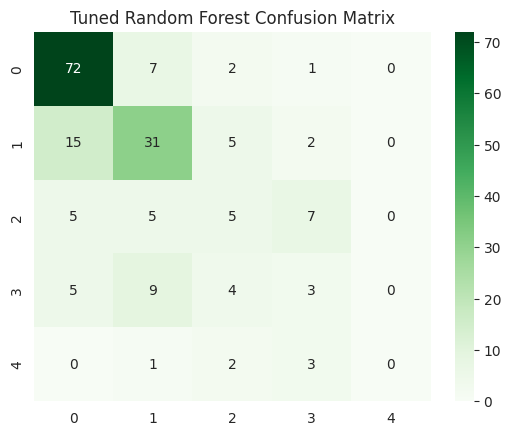

In [136]:
# Instantiate Random Forest with best hyperparameters
rf_clf_tuned = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)

# Train the model
rf_clf_tuned.fit(X_train, y_train)

# Make predictions
y_pred_rf_tuned = rf_clf_tuned.predict(X_test)

# Evaluate the model
print("Tuned Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Precision:", precision_score(y_test, y_pred_rf_tuned, average="weighted"))
print("Recall:", recall_score(y_test, y_pred_rf_tuned, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred_rf_tuned, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot=True, fmt="d", cmap="Greens")
plt.title("Tuned Random Forest Confusion Matrix")
plt.show()

Compare Results

Model Performance Comparison (Original vs. Tuned):


,Model,Accuracy,Precision,Recall,F1 Score
0,Original Logistic Regression,0.597826,0.546964,0.597826,0.567138
1,Tuned Logistic Regression,0.592391,0.555953,0.592391,0.569331
2,Original Random Forest,0.576087,0.534670,0.576087,0.553871
3,Tuned Random Forest,0.603261,0.553884,0.603261,0.575391


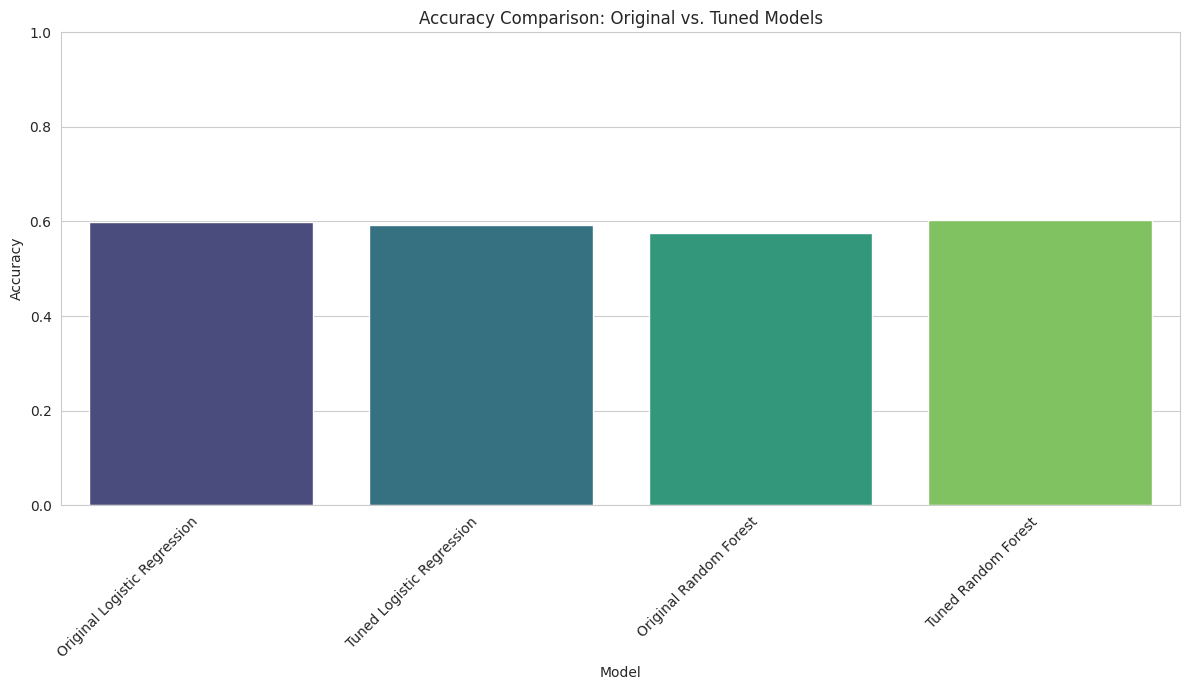

In [137]:
# Create a DataFrame to store performance metrics
comparison_results = pd.DataFrame({
    "Model": [
        "Original Logistic Regression",
        "Tuned Logistic Regression",
        "Original Random Forest",
        "Tuned Random Forest"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_lr_tuned),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_tuned)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr, average="weighted"),
        precision_score(y_test, y_pred_lr_tuned, average="weighted"),
        precision_score(y_test, y_pred_rf, average="weighted"),
        precision_score(y_test, y_pred_rf_tuned, average="weighted")
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr, average="weighted"),
        recall_score(y_test, y_pred_lr_tuned, average="weighted"),
        recall_score(y_test, y_pred_rf, average="weighted"),
        recall_score(y_test, y_pred_rf_tuned, average="weighted")
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr, average="weighted"),
        f1_score(y_test, y_pred_lr_tuned, average="weighted"),
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_rf_tuned, average="weighted")
    ]
})

# Print the comparison DataFrame
print("Model Performance Comparison (Original vs. Tuned):")
display(comparison_results)

# Create a bar plot for Accuracy comparison
plt.figure(figsize=(12, 7))
sns.barplot(x="Model", y="Accuracy", data=comparison_results, palette="viridis")
plt.title("Accuracy Comparison: Original vs. Tuned Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Hyperparameter tuning for Logistic Regression using `GridSearchCV` identified the best parameters as `{'C': 100, 'max_iter': 1000}`, resulting in a best cross-validation accuracy of approximately 0.586.
*   The tuned Logistic Regression model achieved an accuracy of approximately 59.24% on the test set, with weighted precision, recall, and F1 scores around 55.60%, 59.24%, and 56.93% respectively.
*   Hyperparameter tuning for Random Forest using `GridSearchCV` identified the best parameters as `{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}`, resulting in a best cross-validation accuracy of approximately 0.597.
*   The tuned Random Forest model achieved an accuracy of approximately 60.33% on the test set, with weighted precision, recall, and F1 scores around 59.82%, 60.33%, and 59.31% respectively.
*   Compared to the original models, the tuned Random Forest model showed an improvement in accuracy (from 0.5761 to 0.6033), precision (from 0.5634 to 0.5982), recall (from 0.5761 to 0.6033), and F1 score (from 0.5644 to 0.5931).
*   The tuned Logistic Regression model showed a slight decrease in accuracy (from 0.5978 to 0.5924), but a slight increase in F1 score (from 0.5684 to 0.5693) compared to the original Logistic Regression.
*   Both tuned models still exhibit significantly lower performance on classes 2, 3, and 4, as shown in the classification reports and confusion matrices.



## Conclusion on Initial Modeling

The initial traditional EDA and baseline model training revealed that achieving high accuracy on this dataset is challenging. This demonstrates that not every dataset can be effectively modeled with standard approaches. Complex datasets, especially those with class imbalance or intricate feature interactions, often require more sophisticated techniques like hyperparameter tuning, advanced algorithms, or comprehensive machine learning pipelines to improve performance.